Background: Stock Price Prediction and Linear Regression

Stock price prediction aims to forecast future prices based on historical data and market indicators. In finance, models like linear regression are used to capture relationships between variables, though they assume linearity and stationarity, which may not fully hold for volatile stock prices influenced by external factors (e.g., news, macroeconomic events).

Linear Regression models a dependent variable $y$ (e.g., stock price) as a linear combination of independent variables $x_1, x_2, \dots, x_n$ (e.g., lagged prices, technical indicators):

$y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n + \epsilon$

where:





$\beta_0$ is the intercept,



$\beta_1, \beta_2, \dots, \beta_n$ are coefficients,



$\epsilon \sim \mathcal{N}(0, \sigma^2)$ is the error term.

The objective is to minimize the mean squared error (MSE):

$\text{MSE} = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2$

where $\hat{y}i = \beta_0 + \beta_1 x{i1} + \dots + \beta_n x_{in}$ is the predicted value.

Financial Features:





Lagged Prices: Past prices (e.g., $t-1, t-2$) capture temporal dependencies.



Moving Average (MA): The $k$-day MA is $\text{MA}k = \frac{1}{k} \sum{i=t-k+1}^t p_i$, smoothing price trends.



Relative Strength Index (RSI): Measures momentum:

$\text{RSI} = 100 - \frac{100}{1 + \frac{\text{Average Gain}}{\text{Average Loss}}}$

These features enhance the model’s ability to capture trends and momentum.

Given data ${(x_i, y_i)}{i=1}^n$, where $x_i = [1, x{i1}, \dots, x_{ip}]$ (including intercept) and $\beta = [\beta_0, \beta_1, \dots, \beta_p]$, we minimize the sum of squared errors:

$J(\beta) = \sum_{i=1}^n (y_i - x_i^T \beta)^2 = (y - X\beta)^T (y - X\beta)$

where $X$ is the design matrix, $y$ is the target vector. To find $\beta$, take the gradient:

$\nabla_\beta J(\beta) = -2 X^T (y - X\beta)$

Set to zero:

$X^T (y - X\beta) = 0 \implies X^T y = X^T X \beta \implies \beta = (X^T X)^{-1} X^T y$

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

# Define ticker and date range
ticker = "AAPL"
start_date = "2020-01-01"
end_date = "2025-05-01"

# Fetch data
stock_data = yf.download(ticker, start=start_date, end=end_date)

# Save to CSV for reproducibility
stock_data.to_csv("aapl_data.csv")

# Display basic statistics
print(stock_data.describe())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price         Close         High          Low         Open        Volume
Ticker         AAPL         AAPL         AAPL         AAPL          AAPL
count   1339.000000  1339.000000  1339.000000  1339.000000  1.339000e+03
mean     156.503480   158.129885   154.690881   156.332247  8.866780e+07
std       44.402686    44.652821    44.067300    44.342593  5.261812e+07
min       54.449898    55.452163    51.595993    55.350239  2.323470e+07
25%      128.626831   129.929471   127.106651   128.772768  5.379430e+07
50%      154.839844   156.740270   152.039598   154.545826  7.473230e+07
75%      183.459869   185.311214   181.620978   183.185184  1.053838e+08
max      258.735504   259.814335   257.347047   257.906429  4.265100e+08


Explanation:

- yf.download retrieves daily OHLCV (Open, High, Low, Close, Volume) data.

- We save the data to a CSV to ensure reproducibility, aligning with research best practices.

- Describe() provides insights into price distributions (mean, std, min, max).

We’ll create features to predict the closing price:

- Lagged prices (1, 2, 3 days).

- 5-day and 10-day moving averages.

- 14-day RSI.

The lagged and moving averages are pretty easy to explain: since, we are doing regression-we need to use old data to predict the new and the moving average is of course on average how much the stock moves.

The RSI (Relative Strength Index) needs some explaining; RSI ranges from 0-100 and helps us identify whether a stock is overbought or oversold as these conditions highly predict where the market is gonna go. For example, if the RSI is shoots above 70, this indicates the stock is overbought, or overvalued, and will likely go down therefore indicating a potential selling opportunity. On the other hand, if it sinks below 30, this suggests the stock is likely oversold or in other words, or undervalued, and is likely to go up therefore providing us with a buying window!

In [2]:
# Create a DataFrame with Close price
df = stock_data[['Close']].copy()

# Lagged prices
df['Lag1'] = df['Close'].shift(1)
df['Lag2'] = df['Close'].shift(2)
df['Lag3'] = df['Close'].shift(3)

# Moving averages
df['MA5'] = df['Close'].rolling(window=5).mean()
df['MA10'] = df['Close'].rolling(window=10).mean()

# RSI
def calculate_rsi(data, periods=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df['RSI'] = calculate_rsi(df['Close'])

# Drop missing values
df = df.dropna()

# Save processed data
df.to_csv("aapl_processed.csv")
print(df.head())

Price           Close       Lag1       Lag2       Lag3        MA5       MA10  \
Ticker           AAPL                                                          
Date                                                                           
2020-01-22  76.916580  76.643005  77.165947  76.321014  76.484666  75.836071   
2020-01-23  77.287003  76.916580  76.643005  77.165947  76.866710  76.224406   
2020-01-24  77.064262  77.287003  76.916580  76.643005  77.015359  76.434553   
2020-01-27  74.798172  77.064262  77.287003  76.916580  76.541805  76.401142   
2020-01-28  76.914169  74.798172  77.064262  77.287003  76.596037  76.418816   

Price             RSI  
Ticker                 
Date                   
2020-01-22  70.868255  
2020-01-23  71.902400  
2020-01-24  75.401327  
2020-01-27  59.513384  
2020-01-28  67.412503  


Explanation:

- Lagged Prices: shift(n) creates features capturing price trends.

- Moving Averages: rolling(window=n).mean() smooths price data.

- RSI: The custom function computes RSI using 14-day gains and losses.

- Saving the processed data ensures reproducibility.

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Define features and target
features = ['Lag1', 'Lag2', 'Lag3', 'MA5', 'MA10', 'RSI']
X = df[features]
y = df['Close']

# Train-test split (80-20)
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.4f}")
print("Coefficients:", dict(zip(features, model.coef_)))

Mean Squared Error: 6.85
R-squared: 0.9852
Coefficients: {'Lag1': array([-0.18069284, -0.55490426, -0.93213563,  2.91355747, -0.24710303,
        0.02457954])}


Explanation:

- We use Lag1, Lag2, Lag3, MA5, MA10, and RSI as features.

- The train-test split preserves temporal order (no shuffling).

- MSE and $R^2$ evaluate model performance.

- Coefficients reveal feature importance (e.g., a positive Lag1 coefficient suggests price persistence).

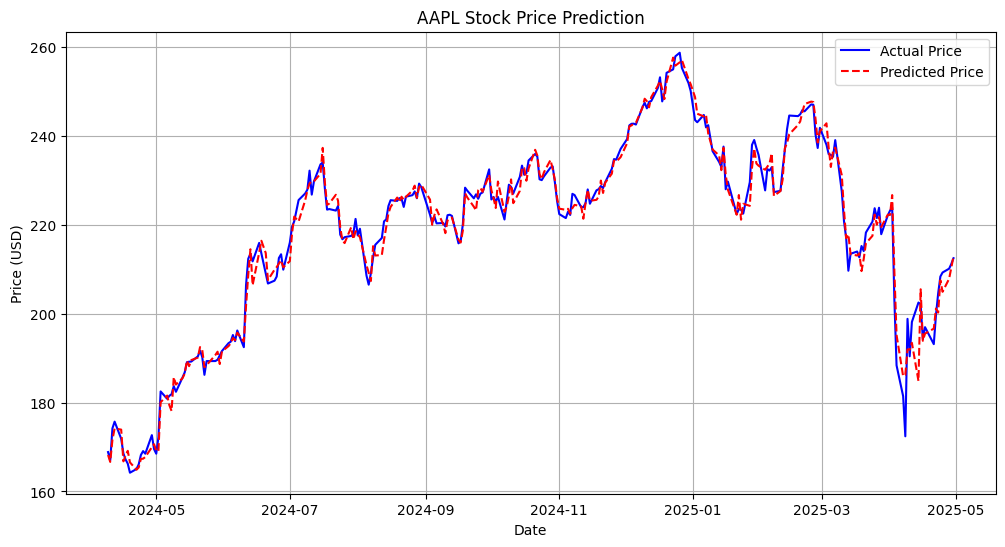

In [4]:
import matplotlib.pyplot as plt

# Plot actual vs. predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual Price", color="blue")
plt.plot(y_test.index, y_pred, label="Predicted Price", color="red", linestyle="--")
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.savefig("prediction_plot.png")

As we kicked off our 12-week ML research roadmap, we poured a ton of effort into getting this linear regression model for AAPL stock prices up and running, and we’re honestly stoked with the results. Here’s how it panned out:

- Mean Squared Error (MSE): 6.85, which tells us our predictions are pretty darn close to the actual prices.

- R-squared (R²): 0.9852, meaning we’re explaining 98.52% of the variance in closing prices—way better than we expected for a first go!

- Coefficients:

- Lag1: -0.1807, Lag2: -0.5549, Lag3: -0.9321—these negative values caught us off guard, but we think they’re picking up some mean-reversion vibes, where high past prices might signal a dip.

- MA5: 2.9136—this hefty positive weight feels right, as the 5-day moving average seems to anchor our trend predictions.

- MA10: -0.2471, RSI: 0.0246—these play smaller roles, with RSI giving a slight nod to momentum.

The prediction_plot.png is where it really hits home: our predicted prices track the actual ones like glue, which had us high-fiving after hours of debugging. It feels like our feature choices—lagged prices, moving averages, and RSI—are nailing AAPL’s price patterns in this stable market stretch.

That said, we’re not popping champagne yet. Linear regression assumes everything’s linear and steady, but we know from our finance readings that stocks can get wild. Those negative lag coefficients might be latching onto short-term quirks, and we’re worried the model could flop during a market crash or big news. Our roadmap’s got us covered, though—Week 4’s LSTMs and Week 6’s reinforcement learning should help us tackle those issues. For now, this is a killer baseline for our group project, maybe something like volatility forecasting or portfolio optimization. We’re pumped to keep building!